In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn import preprocessing
from datetime import datetime, date

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [20]:
user_info = pd.read_csv('../../data/data_format1/user_info_format1.csv')
train_data = pd.read_csv('../../data/data_format1/train_format1.csv')
test_data = pd.read_csv('../../data/data_format1/test_format1.csv')

user_feature_data = pd.read_csv('../../data/feature/user_feature_train_1.csv')
user_feature_test_data = pd.read_csv('../../data/feature/user_feature_test_1.csv')

#### 训练数据合并

In [5]:
#将用户信息和特征及label合并
user_feature_data_2 = pd.merge(user_feature_data, user_info, how='left', on=['user_id'])
user_feature_data_2 = pd.merge(user_feature_data_2, train_data, how='left', on=['user_id', 'merchant_id'])

In [6]:
user_feature_test_data_2 = pd.merge(user_feature_test_data, user_info, how='left', on=['user_id'])
user_feature_test_data_2.to_csv('../../data/feature/user_feature_test_2.csv', index=False)

In [2]:
user_feature_data_2 = pd.read_csv('../../data/feature/user_feature_train_2.csv')

#### 测试数据合并

In [22]:
user_feature_test_data_2 = pd.merge(user_feature_test_data, user_info, how='left', on=['user_id'])
user_feature_test_data_2.to_csv('../../data/feature/user_feature_test_2.csv', index=False)

#### 处理缺失值
对于年龄和性别的缺失,想想办法填充先

In [3]:
user_feature_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 22 columns):
Unnamed: 0                      260864 non-null int64
user_id                         260864 non-null int64
merchant_id                     260864 non-null int64
user_viewed_action_count        260864 non-null int64
user_viewed_item_cat_num        260864 non-null int64
user_viewed_item_brand_num      260864 non-null int64
user_viewed_item_num            260864 non-null int64
user_viewed_item_click          260864 non-null int64
user_viewed_item_addcart        260864 non-null int64
user_viewed_item_buy            260864 non-null int64
user_viewed_item_addcat         260864 non-null int64
user_addcart_ratio              260864 non-null float64
user_click_ratio                260864 non-null float64
user_buy_ratio                  260864 non-null float64
user_addcat_ratio               260864 non-null float64
user_buy_ratio2                 260864 non-null float64
repeat_viewed_c

In [7]:
null_aga = user_info[user_info['age_range'].isna() | (user_info['age_range'] == 0)].count()
null_gender = user_info[user_info['gender'].isna() | (user_info['gender'] == 2)].count()

user_id      95131
age_range    92914
gender       90664
dtype: int64
user_id      16862
age_range    14664
gender       10426
dtype: int64


In [21]:
#填为0
user_info['gender'].fillna(2, inplace=True)
user_info['age_range'].fillna(0, inplace=True)

#### 性别不均

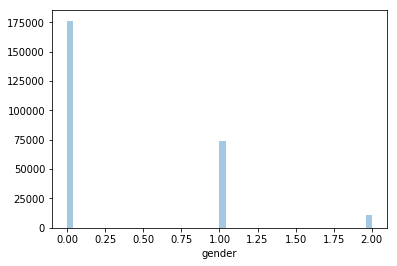

In [7]:
sns.distplot(user_feature_data_2['gender'], kde=False)

#### 年龄也是

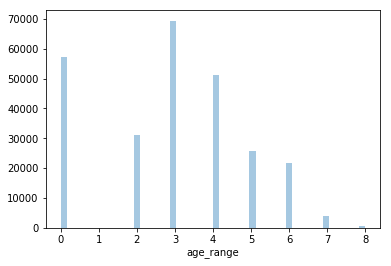

In [8]:
sns.distplot(user_feature_data_2['age_range'], kde=False)

#### 看看训练集的分布

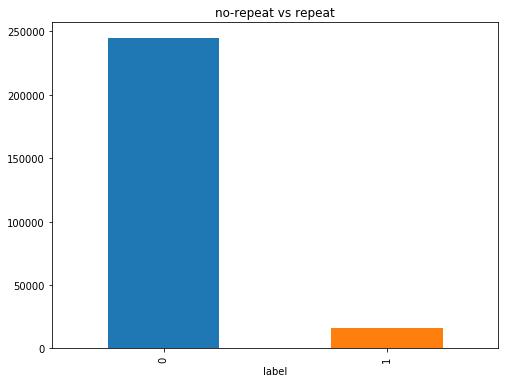

In [17]:
label_gp = user_feature_data_2.groupby('label')['user_id'].count()
label_gp.plot(kind='bar',title='no-repeat vs repeat')

正负样本不均衡呀

#### 看看性别和操作次数和重复购买的关系

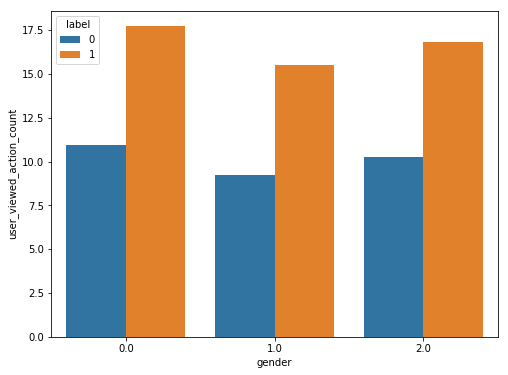

In [15]:
plt.style.use({'figure.figsize':(8, 6)})
sns.barplot(x="gender", y="user_viewed_action_count", hue="label", data=user_feature_data_2, ci=None)

可以看出操作次数多的,重复购买多,这个特征还挺明显的,感觉性别都很均匀

#### 看看年龄和操作次数和重复购买的关系

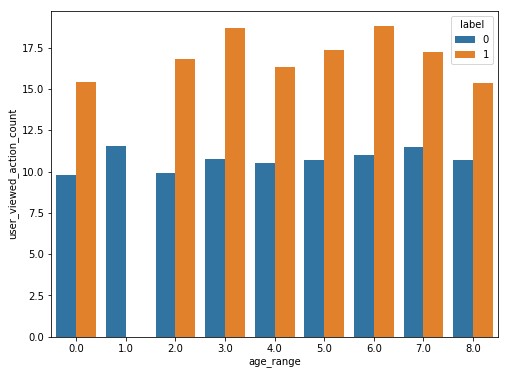

In [20]:
plt.style.use({'figure.figsize':(8, 6)})
sns.barplot(x="age_range", y="user_viewed_action_count", hue="label", data=user_feature_data_2, ci=None)

感觉都比较平均,18岁的没有买过

#### 看各个缺失值占比

In [7]:
train_data = user_feature_data_2

train_data[(train_data['gender'] == 2) & (train_data['label']==1)].count() / train_data[(train_data['gender'] == 2)].count()

train_data[train_data['label']==1].count() / train_data.count()

train_data[(train_data['age_range'] == 0) & (train_data['label']==1)].count() / train_data[(train_data['age_range'] == 0)].count()

train_data[((train_data['gender'] == 2) | (train_data['age_range'] == 0)) & (train_data['label']==1)].count() / train_data.count()

train_data[(train_data['age_range'] == 0) & (train_data['label']==1)].count() / train_data.count()

train_data[train_data['label']==1].count() / train_data.count()

user_id                         0.061151
merchant_id                     0.061151
user_viewed_action_count        0.061151
user_viewed_item_cat_num        0.061151
user_viewed_item_brand_num      0.061151
user_viewed_item_num            0.061151
user_viewed_item_click          0.061151
user_viewed_item_addcart        0.061151
user_viewed_item_buy            0.061151
user_viewed_item_addcat         0.061151
user_addcart_ratio              0.061151
user_click_ratio                0.061151
user_buy_ratio                  0.061151
user_addcat_ratio               0.061151
user_buy_ratio2                 0.061151
repeat_viewed_count             0.061151
repeat_buyer_same_item_count    0.061151
repeat_buyer_diff_item_count    0.061151
age_range                       0.061151
gender                          0.061151
label                           0.061151
dtype: float64

In [8]:
train_data[(train_data['age_range'] == 0) & (train_data['label']==1)].count() / train_data[(train_data['label']==1)].count()

user_id                         0.20825
merchant_id                     0.20825
user_viewed_action_count        0.20825
user_viewed_item_cat_num        0.20825
user_viewed_item_brand_num      0.20825
user_viewed_item_num            0.20825
user_viewed_item_click          0.20825
user_viewed_item_addcart        0.20825
user_viewed_item_buy            0.20825
user_viewed_item_addcat         0.20825
user_addcart_ratio              0.20825
user_click_ratio                0.20825
user_buy_ratio                  0.20825
user_addcat_ratio               0.20825
user_buy_ratio2                 0.20825
repeat_viewed_count             0.20825
repeat_buyer_same_item_count    0.20825
repeat_buyer_diff_item_count    0.20825
age_range                       0.20825
gender                          0.20825
label                           0.20825
dtype: float64

如果直接去掉年龄和性别缺省值,感觉差别很大,会干掉正样本20%